In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
def get_result_df(target_directory, combine=False):

    files = [file for file in os.listdir(target_directory) if file.endswith('.csv')]
    
    if len(files) < 10:
        result_df = pd.read_csv(os.path.join(target_directory, files[0]), index_col=0)
    else:
        result_df = pd.DataFrame()
        filename = '_'.join(files[0].split('_')[1:])

        for file in files:
            df = pd.read_csv(os.path.join(target_directory, file))
            df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
            df['index'] = df['index'].astype(int)
            df['exp_id'] = file.split('_')[0]
            df['exp_id'] = df['exp_id'].astype(int)
            
            result_df = pd.concat([result_df, df]).reset_index(drop=True)

            if combine:
                os.remove(os.path.join(target_directory, file))

        if combine:
            result_df.to_csv(f"{target_directory}/{filename}")
        
    return result_df

def get_benchmark_df():
    asdf = pd.read_csv('/Users/jadonng/Desktop/MarketMaking/log/Simulation/AvellanedaStoikov/Classic/AS_k1p5_sigma2.csv',index_col=0)
    symdf = pd.read_csv('/Users/jadonng/Desktop/MarketMaking/log/Simulation/Symmetric/Symmetric_ASspread.csv',index_col=0)
    asdf['rewardfunc'] = 'inventory'
    symdf['rewardfunc'] = 'symmetric'
    asdf['algo'] = 'inventory'
    symdf['algo'] = 'symmetric'
    benchmark_df = pd.concat([asdf, symdf]).reset_index(drop=True)
    return benchmark_df

def get_result_df_byrewardfunc(target_directory):
    result_df = pd.DataFrame()
    files = []
    for root, dirs, files in os.walk(target_directory):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path, index_col=0)
                df['rewardfunc'] = file.split('_')[0]
                result_df = pd.concat([result_df, df]).reset_index(drop=True)
    return result_df

In [7]:
def get_terminal_wealth(df):
    grouped_df = df[['exp_id','index','wealth']].groupby(['exp_id','index']).sum()
    Twealth = grouped_df['wealth'].groupby(level=0).apply(lambda x: x.iloc[-1])
    return Twealth

def get_cumreward(df):
    grouped_df = df.groupby(['exp_id', 'index']).sum()
    cum_reward_byexp = grouped_df['reward'].groupby(level=0).cumsum().groupby(level=0).apply(lambda x: x.iloc[-1])
    return cum_reward_byexp

def get_MAP(df):
    df = df.copy()
    df['inv'] = abs(df['inv'])
    MAP = df[['exp_id','inv']].groupby(['exp_id']).mean()
    return pd.Series(MAP.unstack())['inv']

def get_MP(df):
    df = df.copy()
    MAP = df[['exp_id','inv']].groupby(['exp_id']).mean()
    return pd.Series(MAP.unstack())['inv']

def get_wealthstd(df):
    wealthstd = df[['exp_id','wealth']].groupby(['exp_id']).std()
    return wealthstd['wealth']

def get_PnLMAP(df):
    return get_terminal_wealth(df)/get_MAP(df)

# Simulation Results

In [190]:
algorithms = ['DQN', 'PPO','MonteCarlo','TCQLearning', 'TCSARSA']
sim_dir = '/Users/jadonng/Desktop/MarketMaking/log/Simulation/'
training_dir = '/Users/jadonng/Desktop/MarketMaking/log/Training/'
simulation_df = pd.DataFrame()
for algorithm in algorithms:
    df = get_result_df_byrewardfunc(sim_dir+algorithm)
    df['algo'] = algorithm
    simulation_df = pd.concat([simulation_df, df]).reset_index(drop=True)
    
benchmark_df = get_benchmark_df()
simulation_df = pd.concat([benchmark_df, simulation_df]).reset_index(drop=True)
simulation_df['algoreward'] = simulation_df['algo'] + '_' + simulation_df['rewardfunc']

In [175]:
result_df['Wealth std.'] = simulation_df.groupby('algoreward').apply(get_wealthstd).mean(axis=1)

In [151]:
result_df = pd.DataFrame()
result_df['Terminal Wealth'] = simulation_df.groupby('algoreward').apply(get_terminal_wealth).mean(axis=1)
result_df['Wealth std.'] = simulation_df.groupby('algoreward').apply(get_wealthstd).mean(axis=1)
result_df['MAP']= simulation_df.groupby('algoreward').apply(get_MAP).mean(axis=1)
result_df['Episodic Return'] = simulation_df.groupby('algoreward').apply(get_cumreward).mean(axis=1)
result_df['PnLMAP'] = simulation_df.groupby('algoreward').apply(get_PnLMAP).mean(axis=1)
result_df.index = simulation_df[['algoreward','wealth']].groupby(['algoreward']).mean().index

In [196]:
result_df.loc['inventory_inventory','Episodic Return'] = None
result_df.loc['symmetric_symmetric','Episodic Return'] = None

result_df.sort_values(by='PnLMAP',ascending=False)

,Terminal Wealth,Wealth std.,MAP,Episodic Return,PnLMAP
algoreward,,,,,
PPO_invpen,59.495140,17.280501,0.547150,48.623436,110.986514
DQN_invpen,58.079000,16.942983,0.762689,42.916880,77.647280
PPO_asymdamp,64.227526,18.680463,0.951159,56.280437,70.287214
inventory_inventory,64.726417,18.777720,0.989759,NaN,68.009254
DQN_asymdamp,63.494920,18.492532,0.972946,53.999249,67.535055
PPO_utility,66.595730,19.354344,1.691298,59.935688,44.490531
TCSARSA_invpen,62.967864,18.517524,2.493774,13.196360,29.940834
symmetric_symmetric,68.118599,20.044692,4.462171,NaN,20.521413
TCQLearning_invpen,60.293660,17.877204,4.289016,-25.073020,17.952887


In [201]:
result_df.to_csv('result_df.csv')
simulation_df.to_csv('simulation_df.csv')

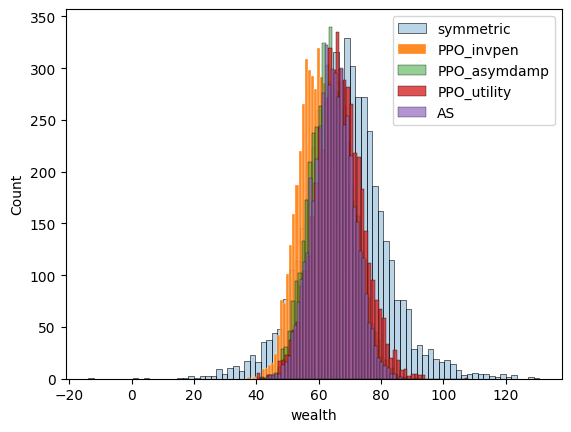

In [202]:
sns.histplot(get_terminal_wealth(simulation_df[simulation_df['algoreward']=='symmetric_symmetric']), alpha=0.3,label='symmetric', edgecolor='black')
sns.histplot(get_terminal_wealth(simulation_df[simulation_df['algoreward']=='PPO_invpen']), alpha=0.9,label='PPO_invpen', edgecolor='white')
sns.histplot(get_terminal_wealth(simulation_df[simulation_df['algoreward']=='PPO_asymdamp']), alpha=0.5,label='PPO_asymdamp', edgecolor='black')
sns.histplot(get_terminal_wealth(simulation_df[simulation_df['algoreward']=='PPO_utility']), alpha=0.8,label='PPO_utility', edgecolor='black')
sns.histplot(get_terminal_wealth(simulation_df[simulation_df['algoreward']=='inventory_inventory']), alpha=0.7,label='AS', edgecolor='black')

plt.legend()

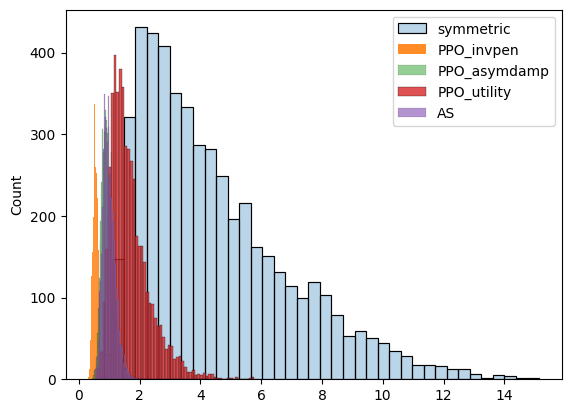

In [200]:
sns.histplot(get_MAP(simulation_df[simulation_df['algoreward']=='symmetric_symmetric']), alpha=0.3,label='symmetric', edgecolor='black')
sns.histplot(get_MAP(simulation_df[simulation_df['algoreward']=='PPO_invpen']), alpha=0.9,label='PPO_invpen', edgecolor='white')
sns.histplot(get_MAP(simulation_df[simulation_df['algoreward']=='PPO_asymdamp']), alpha=0.5,label='PPO_asymdamp', edgecolor='black')
sns.histplot(get_MAP(simulation_df[simulation_df['algoreward']=='PPO_utility']), alpha=0.8,label='PPO_utility', edgecolor='black')
sns.histplot(get_MAP(simulation_df[simulation_df['algoreward']=='inventory_inventory']), alpha=0.7,label='AS', edgecolor='black')

plt.legend()

# Training results

In [5]:
algorithms = ['DQN', 'PPO','MonteCarlo','TCQLearning', 'TCSARSA', 'SARSA']
training_dir = '/Users/jadonng/Desktop/MarketMaking/log/Training/'
training_df = pd.DataFrame()
for algorithm in algorithms:
    df = get_result_df_byrewardfunc(training_dir+algorithm)
    df['algo'] = algorithm
    training_df = pd.concat([training_df, df]).reset_index(drop=True)
    
training_df['algoreward'] = training_df['algo'] + '_' + training_df['rewardfunc']

In [6]:
training_df2 = training_df[training_df['exp_id']<=10000]

In [7]:
cumrew_df = pd.DataFrame()
for i in training_df2['algoreward'].unique():
    df = pd.DataFrame(get_cumreward(training_df2[training_df2['algoreward']==i]))
    df.rename(columns={'reward':i},inplace=True)
    cumrew_df = pd.concat([cumrew_df, df],axis=1)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cumrew_df_normalized = pd.DataFrame(scaler.fit_transform(cumrew_df), columns=cumrew_df.columns)

In [9]:
cumrew_df_normalized

,DQN_invpen,DQN_asymdamp,DQN_utility,PPO_invpen,PPO_asymdamp,PPO_utility,MonteCarlo_invpen,MonteCarlo_asymdamp,MonteCarlo_utility,TCQLearning_invpen,TCQLearning_asymdamp,TCQLearning_utility,TCSARSA_invpen,TCSARSA_asymdamp,TCSARSA_utility,SARSA_asymdamp
0,0.829342,0.801852,0.783828,0.372501,0.473530,0.430268,0.805374,0.796011,NaN,0.278651,0.656693,0.783570,0.526811,0.927215,0.754567,0.803474
1,0.637099,0.849131,0.792852,0.410579,0.286064,0.148457,0.694299,0.830953,NaN,0.767191,0.782455,0.513192,0.792131,0.524684,0.845775,0.917752
2,0.766948,0.714318,0.832547,0.533038,0.079756,0.355677,0.618938,0.534261,0.651507,0.779306,0.807188,0.653270,0.771936,0.541772,0.845760,0.879479
3,0.683305,0.753768,0.541418,0.730490,0.449420,0.404117,0.807995,0.668352,0.813604,0.563851,0.879703,0.837410,0.716922,0.907595,0.788494,0.554832
4,0.895447,0.493569,0.782973,0.624232,0.372331,0.302286,0.596003,0.581989,0.567328,0.727570,0.634939,0.705885,0.808496,0.468671,0.802372,0.804560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.917707,0.890814,0.198560,0.952894,0.764327,0.862205,0.919725,0.701719,0.946760,0.754093,0.520630,0.775508,0.894847,0.627848,0.741012,0.814875
9997,0.931197,0.849467,0.586574,0.904597,0.846345,0.825755,0.891874,0.839305,0.777005,0.816634,0.603899,0.772251,0.935933,0.818987,0.589066,0.593377
9998,0.923440,0.785832,0.563779,0.926309,0.849078,0.769838,0.936435,0.804323,0.819635,0.691225,0.763443,0.723160,0.879526,0.901266,0.531978,0.564061
9999,0.892749,0.845637,0.636547,0.925256,0.843678,0.688080,0.869921,0.885471,0.888281,0.876883,0.666800,0.682761,0.794568,0.783861,0.781616,0.743214


Text(0, 0.5, 'normalized episodic return')

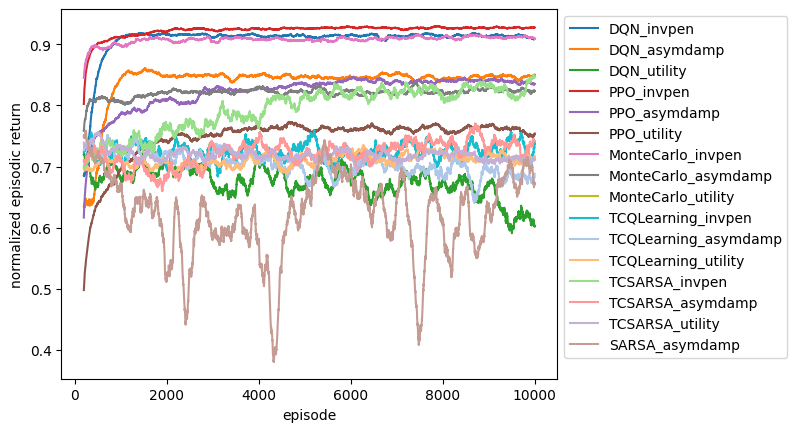

In [12]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']

for c, i in enumerate(cumrew_df_normalized.columns):
    sns.lineplot(cumrew_df_normalized.loc[:,i].rolling(200).mean(), label=i, color=colors[c])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('episode')
plt.ylabel('normalized episodic return')

# Tukey's test

In [3]:
simulation_df = pd.read_csv('simulation_df.csv',index_col=0)

In [8]:
byTwealth = simulation_df.groupby('algoreward').apply(get_terminal_wealth)

In [11]:
byTwealth = byTwealth.T

In [15]:
melted_df = byTwealth.melt(var_name='experiment', value_name='TWealth')

In [16]:
melted_df

,experiment,TWealth
0,DQN_asymdamp,62.900000
1,DQN_asymdamp,66.600000
2,DQN_asymdamp,64.780000
3,DQN_asymdamp,67.500000
4,DQN_asymdamp,61.940000
...,...,...
84995,symmetric_symmetric,61.689276
84996,symmetric_symmetric,69.543906
84997,symmetric_symmetric,65.177743
84998,symmetric_symmetric,60.137743


In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(melted_df['TWealth'], melted_df['experiment'])

tukey_results.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
DQN_asymdamp,DQN_invpen,-5.4159,0.0,-6.2792,-4.5527,True
DQN_asymdamp,DQN_utility,-4.9881,0.0,-5.8514,-4.1249,True
DQN_asymdamp,MonteCarlo_asymdamp,-5.8696,0.0,-6.7328,-5.0063,True
DQN_asymdamp,MonteCarlo_invpen,-6.037,0.0,-6.9003,-5.1738,True
DQN_asymdamp,MonteCarlo_utility,-6.4476,0.0,-7.3109,-5.5844,True
DQN_asymdamp,PPO_asymdamp,0.7326,0.2153,-0.1307,1.5959,False
DQN_asymdamp,PPO_invpen,-3.9998,0.0,-4.863,-3.1365,True
DQN_asymdamp,PPO_utility,3.1008,0.0,2.2376,3.9641,True
DQN_asymdamp,TCQLearning_asymdamp,-1.5275,0.0,-2.3908,-0.6643,True
DQN_asymdamp,TCQLearning_invpen,-3.2013,0.0,-4.0645,-2.338,True


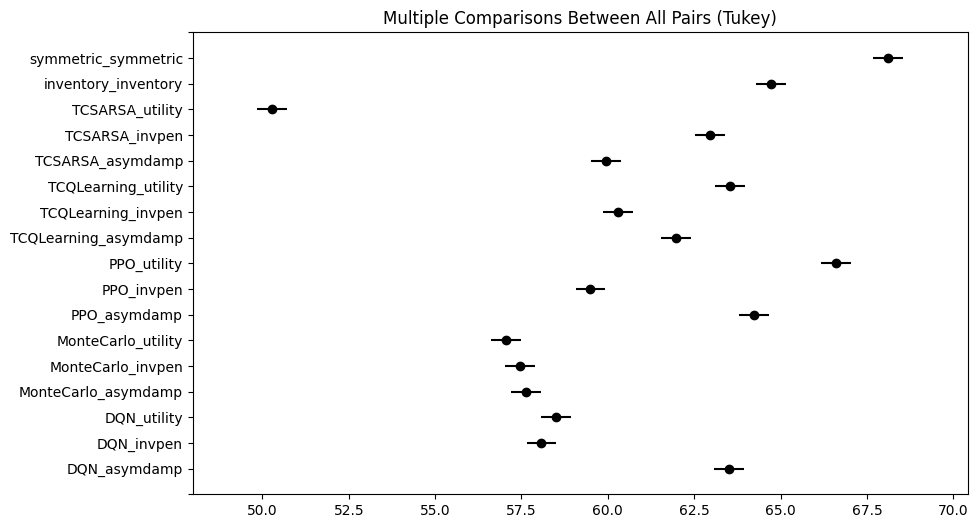

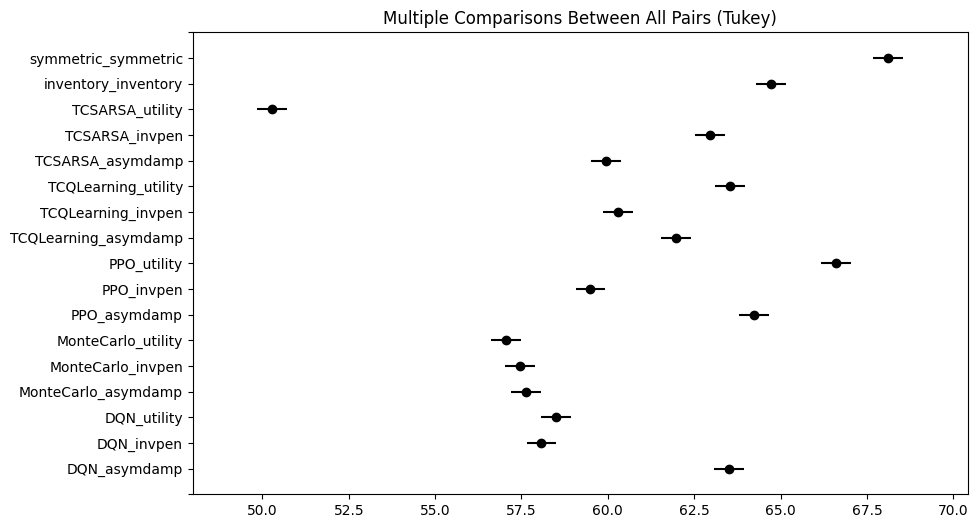

In [21]:
tukey_results.plot_simultaneous()

In [22]:
byMAP = simulation_df.groupby('algoreward').apply(get_MAP)

In [26]:
MAP_melt = byMAP.T.melt(var_name='experiment',value_name='MAP')

In [30]:
MAP_melt

,experiment,MAP
0,DQN_asymdamp,0.889447
1,DQN_asymdamp,0.809045
2,DQN_asymdamp,1.226131
3,DQN_asymdamp,0.834171
4,DQN_asymdamp,1.065327
...,...,...
84995,symmetric_symmetric,5.658291
84996,symmetric_symmetric,5.251256
84997,symmetric_symmetric,1.914573
84998,symmetric_symmetric,4.527638


In [28]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey_results_MAP = pairwise_tukeyhsd(MAP_melt['MAP'], MAP_melt['experiment'])

tukey_results_MAP.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
DQN_asymdamp,DQN_invpen,-0.2103,0.0,-0.3516,-0.0689,True
DQN_asymdamp,DQN_utility,6.2376,0.0,6.0963,6.379,True
DQN_asymdamp,MonteCarlo_asymdamp,3.961,0.0,3.8196,4.1024,True
DQN_asymdamp,MonteCarlo_invpen,4.2968,0.0,4.1554,4.4382,True
DQN_asymdamp,MonteCarlo_utility,3.7166,0.0,3.5753,3.858,True
DQN_asymdamp,PPO_asymdamp,-0.0218,1.0,-0.1632,0.1196,False
DQN_asymdamp,PPO_invpen,-0.4258,0.0,-0.5672,-0.2844,True
DQN_asymdamp,PPO_utility,0.7184,0.0,0.577,0.8597,True
DQN_asymdamp,TCQLearning_asymdamp,4.9026,0.0,4.7612,5.044,True
DQN_asymdamp,TCQLearning_invpen,3.3161,0.0,3.1747,3.4575,True


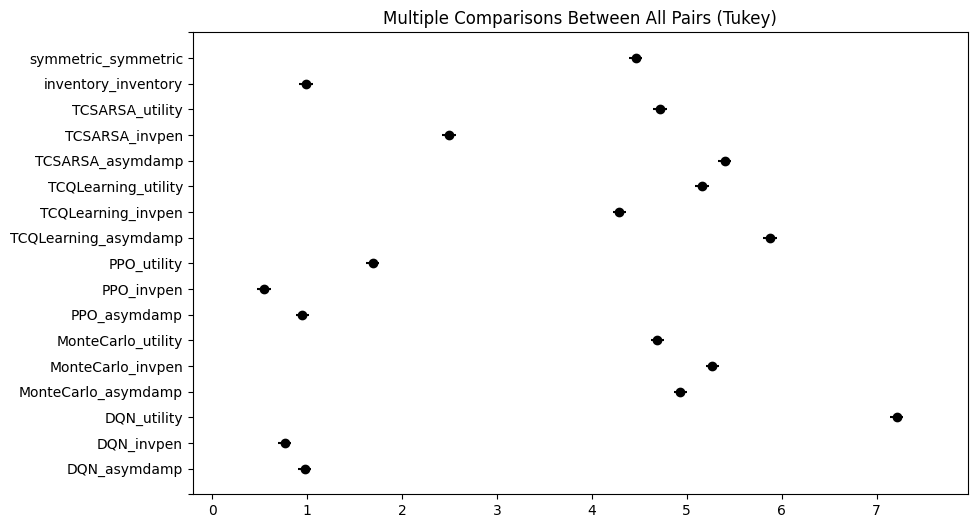

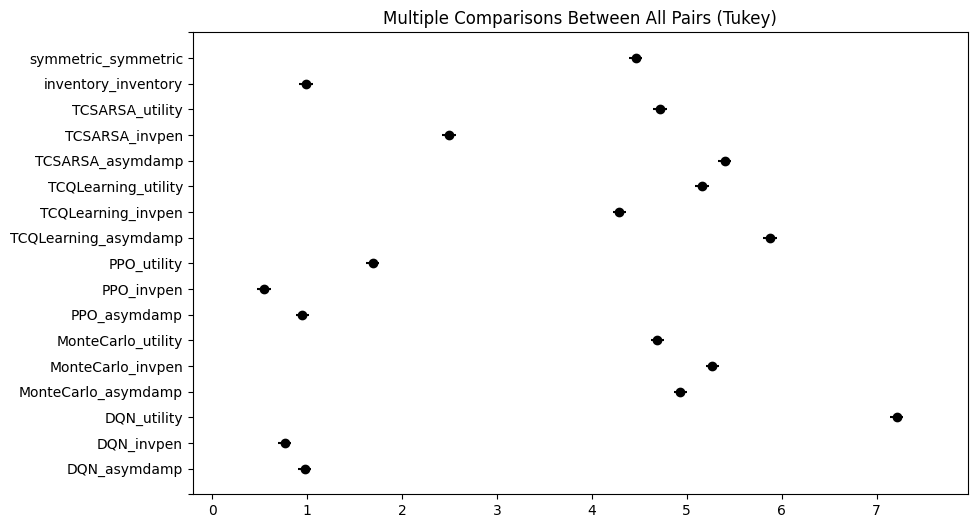

In [29]:
tukey_results_MAP.plot_simultaneous()